### Этот блокнот используется для детальной проверки каждого блока кода

In [1]:
# Импорт необходимых библиотек
import numpy as np
import matplotlib.pyplot as plt
import math as mt
import time
import csv

from numba import njit, jit
from tqdm import trange

from solver import Solver
import functions as func

#### Параметры, константы и т.д.

In [2]:
# Начальные условия среды
P = 101325
U0 = 10
T0 = 300
Tw = 301
PrT = 0.9

properties0 = func.AirProp(T0, T0, P) # Расчёт вектора начальных свойств
den0 = properties0[0]
vis0 = properties0[1]
lam0 = properties0[2]
cp = properties0[3]

# Геометрия и параметры сетки
L = 5
h = 0.4
n = 2000
k = 500

#### Построение сетки

In [3]:
# По х сетка строится таким образом, чтобы за указанное число элементов
# (n) выйти на фиксированные шаг (в данном случае 1е-6).
# Сетка по у генерируется стандартным способом по кол-ву элементов и степени
# сжатия к нижней стенке
xx, yy = func.GrdGen(L, h, n, k, a=1.01, b=1.023)

dy: 100%|██████████| 499/499 [00:00<00:00, 1535552.23it/s]


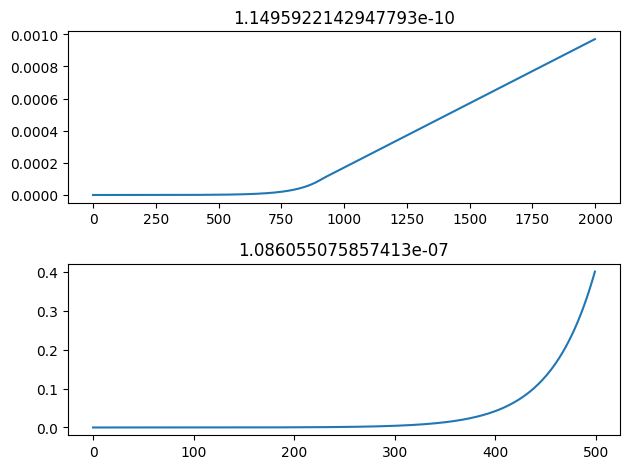

In [4]:
# Отображение сетки для проверки
plt.subplot(2,1,1)
plt.title(xx[1])
plt.plot(xx)
plt.subplot(2,1,2)
plt.title(yy[1])
plt.plot(yy)
plt.tight_layout()

In [5]:
yy[1]

1.086055075857413e-07

#### Инициализация пустых массивов

In [6]:
U = np.zeros((2,k), float)
Uit = np.zeros((k), float)

V = np.zeros((2,k), float)
Vit = np.zeros((k), float)

T = np.zeros((2,k), float)
Tit = np.zeros((k), float)

ka = np.zeros((2,k), float)
kait = np.zeros((k), float)

omega = np.zeros((2,k), float)
omegait = np.zeros((k), float)

gamma = np.zeros((2,k), float)
gammait = np.zeros((k), float)

den  = np.zeros((2,k), float)
denit = np.zeros((k), float)

vis = np.zeros((2,k), float)
visit = np.zeros((k), float)

visT = np.zeros((2,k), float)
visTit = np.zeros((k), float)

lam = np.zeros((2,k), float)
lamit = np.zeros((k), float)

S1 = np.zeros((k), float)
S2 = np.zeros((k), float)

#### Граничные условия

In [7]:
for ii in trange(k):
    den[:,ii] = float(den0)

for ii in trange(k):
    vis[:,ii] = float(vis0)

for ii in trange(k):
    visT[:,ii] = 100 * vis[:,ii]

for ii in trange(k):
    lam[:,ii] = float(lam0)

Tu = 0.065

for jj in range(0, k):
    U[0,jj]            = U0 #mt.erf(0.313 * yy[jj] * np.sqrt(den0 * U0 / vis0 / x0))
    V[0,jj]            = 0.
    T[0,jj]            = T0
    # ka[0,jj] = 1e-5
    # omega[0,jj] = 1e-5
    ka[0,jj] = 1.5 * U0 * Tu * Tu
    Ret = den[0,jj] / vis[0,jj] * ((ka[0,jj]) ** 0.5) * yy[jj]
    Dq = 1. - np.exp(-0.022 * Ret)
    omega[0,jj] = 0.09 * Dq * den[0,jj] * ka[0,jj] / visT[0,jj]

    if yy[jj] / h <= 0.3:
        gamma[0,jj] = 0.
    else:
        gamma[0,jj] = 1.
    # gamma[0,jj] = 1

U[0,0] = 0.
T[0,0] = Tw

100%|██████████| 500/500 [00:00<00:00, 985967.09it/s]


#### Константы и списки для основного цикла

In [8]:
# Инициализация списков для хранения некоторых рассчитываемых параметров
Rex       = []
Cf        = []
Cf_analit = []
Cf_analit_turb = []
# Nu        = []
# Nu_analit = []

x = 0
i = 0
iternum = 300
counter = 0

# Константы источниковых членов ур-ний турбулентности
sigmaom = 2.
Com1 = 5 / 9
Com2 = 3 / 40
gammamax = 1.1
sigmal = 5.
sigmagam = 0.2
sigmak = 2.
Cmu = 0.09

#### Скарб для работы script.py

In [9]:
# Инициализация и очистка файла для мониторинга (script.py)
fieldnames = ["Rex", "Cf", "Cf_analit", "Cf_analit_turb"]
with open('data.csv', 'w') as csv_file:
    csv_writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    csv_writer.writeheader()

#### Основной цикл

/home/konstantin/Documents/РНФ Сахнов/BLkwg/solver.py:23: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "Solver" failed type inference due to: No implementation of function Function(float64) found for signature:
 
 >>> <unknown function>(array(float64, 2d, C))
 
There are 2 candidate implementations:
 - Of which 2 did not match due to:
 Overload in function 'make_callable_template.<locals>.generic': File: numba/core/typing/templates.py: Line 174.
   With argument(s): '(array(float64, 2d, C))':
  Rejected as the implementation raised a specific error:
    TypingError: Casting array(float64, 2d, C) to float64 directly is unsupported. Try doing '<array>.astype(np.float64)' instead
  raised from /home/konstantin/.local/lib/python3.10/site-packages/numba/core/typing/builtins.py:833

During: resolving callee type: class(float64)
During: typing of call at /home/konstantin/Documents/РНФ Сахнов/BLkwg/solver.py (33)


File "solver.py", line 3

| step: 1 ; x: 0.0 ; Re: 0 ; step time: 11732 ms ; iter: 299 ; dx:  1.1495922142947793e-10 ; progress 0.0 % |
| step: 2 ; x: 0.0 ; Re: 0 ; step time: 4222 ms ; iter: 262 ; dx:  1.161088136437727e-10 ; progress 0.0 % |
| step: 3 ; x: 0.0 ; Re: 0 ; step time: 4042 ms ; iter: 250 ; dx:  1.1726990178021044e-10 ; progress 0.0 % |
| step: 4 ; x: 0.0 ; Re: 0 ; step time: 3958 ms ; iter: 247 ; dx:  1.1844260079801253e-10 ; progress 0.0 % |
| step: 5 ; x: 0.0 ; Re: 0 ; step time: 3936 ms ; iter: 245 ; dx:  1.1962702680599265e-10 ; progress 0.0 % |
| step: 6 ; x: 0.0 ; Re: 0 ; step time: 3896 ms ; iter: 243 ; dx:  1.208232970740526e-10 ; progress 0.0 % |
| step: 7 ; x: 0.0 ; Re: 0 ; step time: 3863 ms ; iter: 241 ; dx:  1.220315300447931e-10 ; progress 0.0 % |
| step: 8 ; x: 0.0 ; Re: 0 ; step time: 3841 ms ; iter: 239 ; dx:  1.23251845345241e-10 ; progress 0.0 % |
| step: 9 ; x: 0.0 ; Re: 0 ; step time: 3825 ms ; iter: 239 ; dx:  1.2448436379869353e-10 ; progress 0.0 % |
| step: 10 ; x: 0.0 ; R

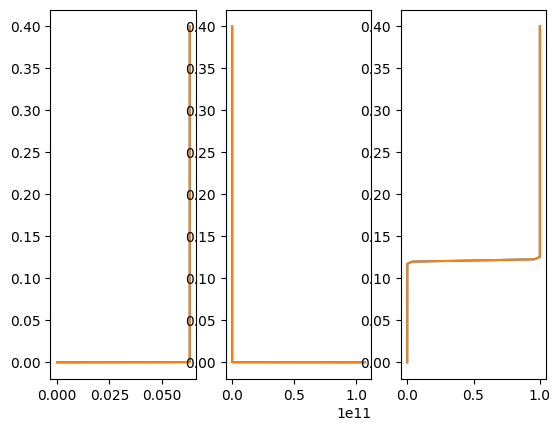

Exception: VisT < 0

In [10]:
while x <= L:
    if i < n-1:
        dx = xx[i+1] - xx[i]
    else:
        dx = 8e-7
    # До определённого момента (i < n-1) сетка посчитана с плавным
    # переходом на постоянный шаг.
    # Далее шаг всегда постоянный

    x += dx # Текущее значение
    i += 1 # Счётчик для расчёта dx

    start = time.time() # Для оценки времени расчёта одного шага

    # Перенос значений с предыдущего шага на текущий
    for jj in range(k):
        U[1,jj] = U[0,jj]
        V[1,jj] = V[0,jj]
        T[1,jj] = T[0,jj]
        ka[1,jj] = ka[0,jj]
        omega[1,jj] = omega[0,jj]
        gamma[1,jj] = gamma[0,jj]
        den[1,jj] = den[0,jj]
        vis[1,jj] = vis[0,jj]
        visT[1,jj] = visT[0,jj]

    # Цикл расчёта текущего шага
    for q in range(iternum):
        # Формирование массивов для проверки сходимости
        for jj in range(k):
            Uit[jj] = U[1,jj]
            Vit[jj] = V[1,jj]
            Tit[jj] = T[1,jj]
            kait[jj] = ka[1,jj]
            omegait[jj] = omega[1,jj]
            gammait[jj] = gamma[1,jj]
            denit[jj] = den[1,jj]
            visit[jj] = vis[1,jj]
            visTit[jj] = visT[1,jj]

        # Momentum equation
        fcond = [0., 1., 0., 0.] # Граничные условия на стенке
        lcond = [0., 1., 0., U0] # Граничные условия в потоке
        for jj in range(1, k):
            S1[jj] = 0. # Источниковый член
            S2[jj] = 0. # Источниковый член
        U, V = Solver(U, den, vis, visT, fcond, lcond, U, V, dx, yy, S1, S2, theta=1, motion_eq=True)
        for jj in range(k):
            V[1,jj] = 0.5 * V[1,jj] + 0.5 * Vit[jj]
        # Для уточнения см. solver.py
        # Проверка правильности выполнения расчёта скоростей
        for kk in range(k):
            if func.isNaN(U[1,kk]):
                print('Programm iterrupt at Rex = ', U[1,k-1] * x * den0 / vis0)
                print('dx = ', dx)
                func.graph(Rex, Cf, Cf_analit, Cf_analit_turb)
                raise Exception('U = Nan')
        for kk in range(k):
            if func.isNaN(V[1,kk]):
                print('Programm iterrupt at Rex = ', U[1,k-1] * x * den0 / vis0)
                print('dx = ', dx)
                func.graph(Rex, Cf, Cf_analit, Cf_analit_turb)
                raise Exception('V = Nan')
        # Далее формат вызова функции Solver() будет происходит аналогично.

        # # Energy equation
        # fcond = [0, 1, 0, T[1,0]]
        # lcond = [0, 1, 0, T[1,len(T[0])-1]]
        # for jj in range(1, len(S1)):
        #     S1[jj] = (vis[1,jj] + visT[1,jj]) * (U[1,jj] - U[1,jj-1]) * (U[1,jj] - U[1,jj-1]) / (yy[jj] - yy[jj-1]) / (yy[jj] - yy[jj-1])
        #     S2[jj] = 0
        # T = Solver(T, cp*den, lam, cp*visT/PrT, fcond, lcond, U, V, dx, yy, S1, S2)
        # for kk in range(len(T[1])):
        #     if isNaN(T[1,kk]):
        #         raise Exception('T = Nan')

        # omega equation
        fcond = [0., 1., 0., 6.*vis[1,0]/den[1,0]/Com2/yy[1]/yy[1]]
        lcond = [-1./(yy[k-1] - yy[k-2]), 1./(yy[k-1] - yy[k-2]), 0., 0.]
        for jj in range(1, k-1):
            dyp = yy[jj+1] - yy[jj]
            dym = yy[jj]   - yy[jj-1]
            S = (0.5 ** 0.5) * ((dyp / dym * (U[1,jj] - U[1,jj-1]) + dym / dyp * (U[1,jj+1] - U[1,jj])) / (dym + dyp))
            S1[jj] = 2. * den[1,jj] * Com1 * S * S
            S2[jj] = - den[1,jj] * Com2 * omega[1,jj] * omega[1,jj]
            if func.isNaN(S1[jj]):
                func.graph(Rex, Cf, Cf_analit, Cf_analit_turb)
                raise Exception('S1 in omega')
            if func.isNaN(S2[jj]):
                func.graph(Rex, Cf, Cf_analit, Cf_analit_turb)
                raise Exception('S2 in omega')
        omega = Solver(omega, den, vis, visT/sigmaom, fcond, lcond, U, V, dx, yy, S1, S2, theta=1)
        for kk in range(k):
            if func.isNaN(omega[1,kk]):
                print('Programm iterrupt at Rex = ', U[1,k-1] * x * den0 / vis0)
                print('dx = ', dx)
                func.graph(Rex, Cf, Cf_analit, Cf_analit_turb)
                raise Exception('omega = Nan')
        relax = 0.04
        for jj in range(k):
            omega[1,jj] = relax * omega[1,jj] + (1 - relax) * omegait[jj]

        #gamma equation
        fcond = [0., -1./yy[1], 1./yy[1], 0.]
        lcond = [0., 1., 0., 1.]
        for jj in range(1, k-1):
            Rt = visT[1,jj] / vis[1,jj]
            Vort = np.abs((U[1,jj] - U[1,jj-1]) / (yy[jj] - yy[jj-1]))
            Tom = Rt * Vort / omega[1,jj]
            Rc = 400. - 360. * min(Tom / 2., 1.)
            Rnu = den[1,jj] * yy[jj] * yy[jj] * Vort / 2.188 / vis[1,jj]
            if (Rnu <= Rc) or (Rnu >= 100. / 0.7):
                Fgam = 0
            if (Rnu > Rc + 4.) and (Rnu <= 100./0.7 - 1):
                Fgam = 8.
            # Fgam = 2. * max(0., min(200. - Rnu, 1.)) * min(max(Rnu - Rc, 0.), 4.)
            Pgam = Fgam * Vort * (gammamax - gamma[1,jj]) * gamma[1,jj] ** 0.5
            Fturb = np.exp(-((Rnu * Rt) ** 1.2))
            if (Rnu <= 18.) or (Rnu >= 100.):
                Ggam = 0.
            if (Rnu > 19.) and (Rnu <= 99.):
                Ggam = 7.5
            # Ggam = 7.5 * max(0, min(100. - Rnu, 1.)) * min(max(Rnu - 18., 0.), 1.)
            Egam = Ggam * Fturb * Vort * gamma[1,jj] ** 1.5
            S1[jj] = den[1,jj] * (Pgam - Egam)
            S2[jj] = 0.
            if func.isNaN(S1[jj]):
                #graph(Rex, Cf, Cf_analit, Cf_analit_turb)
                raise Exception('S1 in gamma')
            if func.isNaN(S2[jj]):
                #graph(Rex, Cf, Cf_analit, Cf_analit_turb)
                raise Exception('S2 in gamma')
        gamma = Solver(gamma, den, vis/sigmal, visT/sigmagam, fcond, lcond, U, V, dx, yy, S1, S2, theta=1)
        for kk in range(k):
            if gamma[1,kk] < 0:
                gamma[1,kk] = 0.
            gamma[1,kk] = min(gamma[1,kk], 1.)
        for kk in range(k):
            if func.isNaN(gamma[1,kk]):
                func.graph(Rex, Cf, Cf_analit, Cf_analit_turb)
                raise Exception('gamma = Nan')
        relax = 0.5
        for jj in range(k):
            gamma[1,jj] = relax * gamma[1,jj] + (1 - relax) * gammait[jj]
        
            
        # ka equation
        fcond = [0., 1., 0., 0.]
        lcond = [-1./(yy[k-1] - yy[k-2]), 1./(yy[k-1] - yy[k-2]), 0., 0.]
        for jj in range(1, k-1):
            dyp = yy[jj+1] - yy[jj]
            dym = yy[jj]   - yy[jj-1]
            S = (0.5 ** 0.5) * ((dyp / dym * (U[1,jj] - U[1,jj-1]) + dym / dyp * (U[1,jj+1] - U[1,jj])) / (dym + dyp))
            Pk = gamma[1,jj] * min(2. * visT[1,jj] * S * S / den[1,jj], ka[1,jj] * np.abs(S) / (3. ** 0.5))
            S1[jj] = den[1,jj] * Pk
            S2[jj] = - Cmu * den[1,jj] * ka[1,jj] * omega[1,jj]
            if func.isNaN(S1[jj]):
                func.graph(Rex, Cf, Cf_analit, Cf_analit_turb)
                raise Exception('S1 in ka')
            if func.isNaN(S2[jj]):
                func.graph(Rex, Cf, Cf_analit, Cf_analit_turb)
                raise Exception('S2 in ka')
        ka = Solver(ka, den, vis, visT/sigmak, fcond, lcond, U, V, dx, yy, S1, S2, theta=1)
        for kk in range(k):
            # if ka[1,kk] < 0:
            #     ka[1,kk] = 1e-10
            if func.isNaN(ka[1,kk]):
                print('Programm iterrupt at Rex = ', U[1,k-1] * x * den0 / vis0)
                print('dx = ', dx)
                func.graph(Rex, Cf, Cf_analit, Cf_analit_turb)
                raise Exception('ka = Nan')
        relax = 0.05
        for jj in range(k):
            ka[1,jj] = relax * ka[1,jj] + (1 - relax) * kait[jj]

        for jj in range(k):
            den[1,jj] = func.AirProp(T[1,jj], T0, P)[0]

        for jj in range(k):
            vis[1,jj] = func.AirProp(T[1,jj], T0, P)[1]

        for jj in range(k):
            visT[1,jj] = den[1,jj] * ka[1,jj] / omega[1,jj]
            if visT[1,jj] < 0:
                print('visT < 0')
                print('ka, omega = ', ka[1,jj], omega[1,jj])
                plt.subplot(1,3,1)
                plt.plot(ka[0], yy)
                plt.plot(ka[1], yy)
                plt.subplot(1,3,2)
                plt.plot(omega[0], yy)
                plt.plot(omega[1], yy)
                plt.subplot(1,3,3)
                plt.plot(gamma[0], yy)
                plt.plot(gamma[1], yy)
                plt.show()
                raise Exception('VisT < 0')
                visT[1,jj] = 0
            if func.isNaN(visT[1,jj]):
                print('ka, omega = ', ka[1,jj], omega[1,jj])
                func.graph(Rex, Cf, Cf_analit, Cf_analit_turb)
                raise Exception('VisT takes NaN')

        key1 = 0
        key1 = func.quality_chek(U, Uit, key1)

        key2 = 0
        key2 = func.quality_chek(V, Vit, key2)

        key3 = 0
        key3 = func.quality_chek(T, Tit, key3)

        key4 = 0
        key4 = func.quality_chek(den, denit, key4)

        key5 = 0
        key5 = func.quality_chek(vis, visit, key5)

        key6 = 0
        key6 = func.quality_chek(visT, visTit, key6)

        key6 = 0
        key6 = func.quality_chek(visT, visTit, key6)

        key7 = 0
        key7 = func.quality_chek(ka, kait, key7)

        key8 = 0
        key8 = func.quality_chek(omega, omegait, key8)

        key9 = 0
        key9 = func.quality_chek(gamma, gammait, key9)

        if (key1 == 0 and key2 == 0 and key3 == 0\
                      and key4 == 0 and key5 == 0\
                      and key6 == 0 and key7 == 0\
                      and key8 == 0 and key9 == 0):
            break

    # Перенос значений с текущего шага на предыдущий
    for jj in range(k):
        U[0,jj] = U[1,jj]
        V[0,jj] = V[1,jj]
        T[0,jj] = T[1,jj]
        ka[0,jj] = ka[1,jj]
        omega[0,jj] = omega[1,jj]
        gamma[0,jj] = gamma[1,jj]
        den[0,jj] = den[1,jj]
        vis[0,jj] = vis[1,jj]
        visT[0,jj] = visT[1,jj]

    end = time.time()

    # Вывод некоторых параметров в консоль
    # if i % 50 == 0:
    print('|', 'step:', i, '; x:', round(x, 3), '; Re:', round(U[1,k-1] * x * den0 / vis0), '; step time:', round((end - start)*1000), 'ms', '; iter:', q, '; dx: ', dx, '; progress', round(x * 100 / L, 3), '% |')
    
    Rex.append(U[1,k-1] * x * den0 / vis0)
    Cf.append(vis0 * ((U[1,1] - U[1,0]) / (yy[1] - yy[0]))/(den0 * U[1,k-1] * U[1,k-1]))
    Cf_analit.append(0.332/np.sqrt(U[1,k-1] * x * den0 / vis0))
    Cf_analit_turb.append(0.0296 * (U[1,k-1] * x * den0 / vis0) ** (-0.2))
    # Nu.append(-lam0 * x * ((T[1,1] - T[1,0]) / (yy[1] - yy[0])) / ((Tw - T[1,k-1]) * lam0))
    # Nu_analit.append(0.332 * (U[1,k-1] * x * den0 / vis0)**(0.5) * Pr**(0.333))

    # Запись в файл параметров для мониторинга (script.py)
    if i % 10 == 0:
        with open('data.csv', 'a') as csv_file:
            csv_writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

            info = {
                "Rex": (U[1,k-1] * x * den0 / vis0),
                "Cf": (vis0 * ((U[1,1] - U[1,0]) / (yy[1] - yy[0]))/(den0 * U[1,k-1] * U[1,k-1])),
                "Cf_analit": (0.332/np.sqrt(U[1,k-1] * x * den0 / vis0)),
                "Cf_analit_turb": (0.0296 * (U[1,k-1] * x * den0 / vis0) ** (-0.2)),
            }
            
            csv_writer.writerow(info)

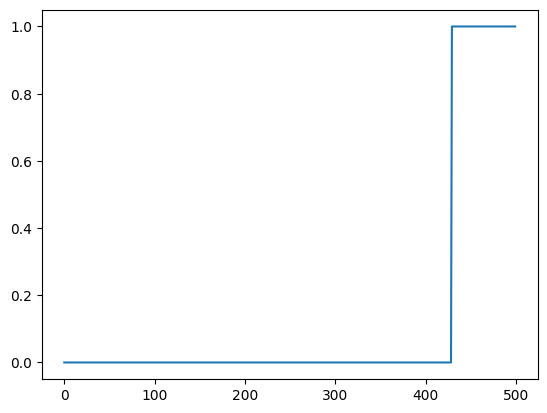

In [ ]:
plt.plot(gamma[1])